## Importowanie bibliotek

In [1]:
import os
import cv2 #pip install opencv-python
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torchvision
import torch
import albumentations as A #pip install albumentations (before importing cv2)
from torch import nn
import timm
from tqdm.notebook import tqdm

## Ładowanie danych

In [2]:
annot_dir = "dataset/annotations/"
img_dir = "dataset/images/"

annot_list = sorted([os.path.join(annot_dir, annot) for annot in os.listdir(annot_dir)])
img_list = sorted([os.path.join(img_dir, img) for img in os.listdir(img_dir)])

# Usuwanie 2 błędnych obrazków
annot_list.remove("dataset/annotations/potholes58.xml")
annot_list.remove("dataset/annotations/potholes214.xml")
img_list.remove("dataset/images/potholes58.png")
img_list.remove("dataset/images/potholes214.png")

In [3]:
def get_data_from_xml(path):
        tree = ET.parse(path)
        root = tree.getroot()
        
        width = int(root.find("size").find("width").text)
        height = int(root.find("size").find("height").text)
        boxes = []
        
        for obj in root.findall("object"):
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            
            boxes.append([xmin, ymin, xmax, ymax])
            
        return boxes, height, width

In [4]:
data = {"path":[], "img":[], "width":[], "height":[], "xmin":[], "ymin":[], "xmax":[], "ymax":[]}
for i in range(len(img_list)):
    img = cv2.imread(img_list[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    xml_data = get_data_from_xml(annot_list[i])
    for j in range(len(xml_data[0])):
        xmin, ymin, xmax, ymax = xml_data[0][j]
        data["path"].append(img_list[i])
        data["img"].append(img)
        data["width"].append(xml_data[2])
        data["height"].append(xml_data[1])
        data["xmin"].append(xmin)
        data["ymin"].append(ymin)
        data["xmax"].append(xmax)
        data["ymax"].append(ymax)
data = pd.DataFrame(data)

In [5]:
data.head()

path  \
0  dataset/images/potholes0.png   
1  dataset/images/potholes0.png   
2  dataset/images/potholes0.png   
3  dataset/images/potholes0.png   
4  dataset/images/potholes0.png   

                                                 img  width  height  xmin  \
0  [[[79, 69, 60], [128, 118, 109], [118, 105, 96...    450     300   141   
1  [[[79, 69, 60], [128, 118, 109], [118, 105, 96...    450     300   201   
2  [[[79, 69, 60], [128, 118, 109], [118, 105, 96...    450     300    87   
3  [[[79, 69, 60], [128, 118, 109], [118, 105, 96...    450     300   181   
4  [[[79, 69, 60], [128, 118, 109], [118, 105, 96...    450     300   236   

   ymin  xmax  ymax  
0   233   203   262  
1   219   238   236  
2   172   147   196  
3   171   212   185  
4   175   272   185

## Pokazanie przykładowych zdjęć

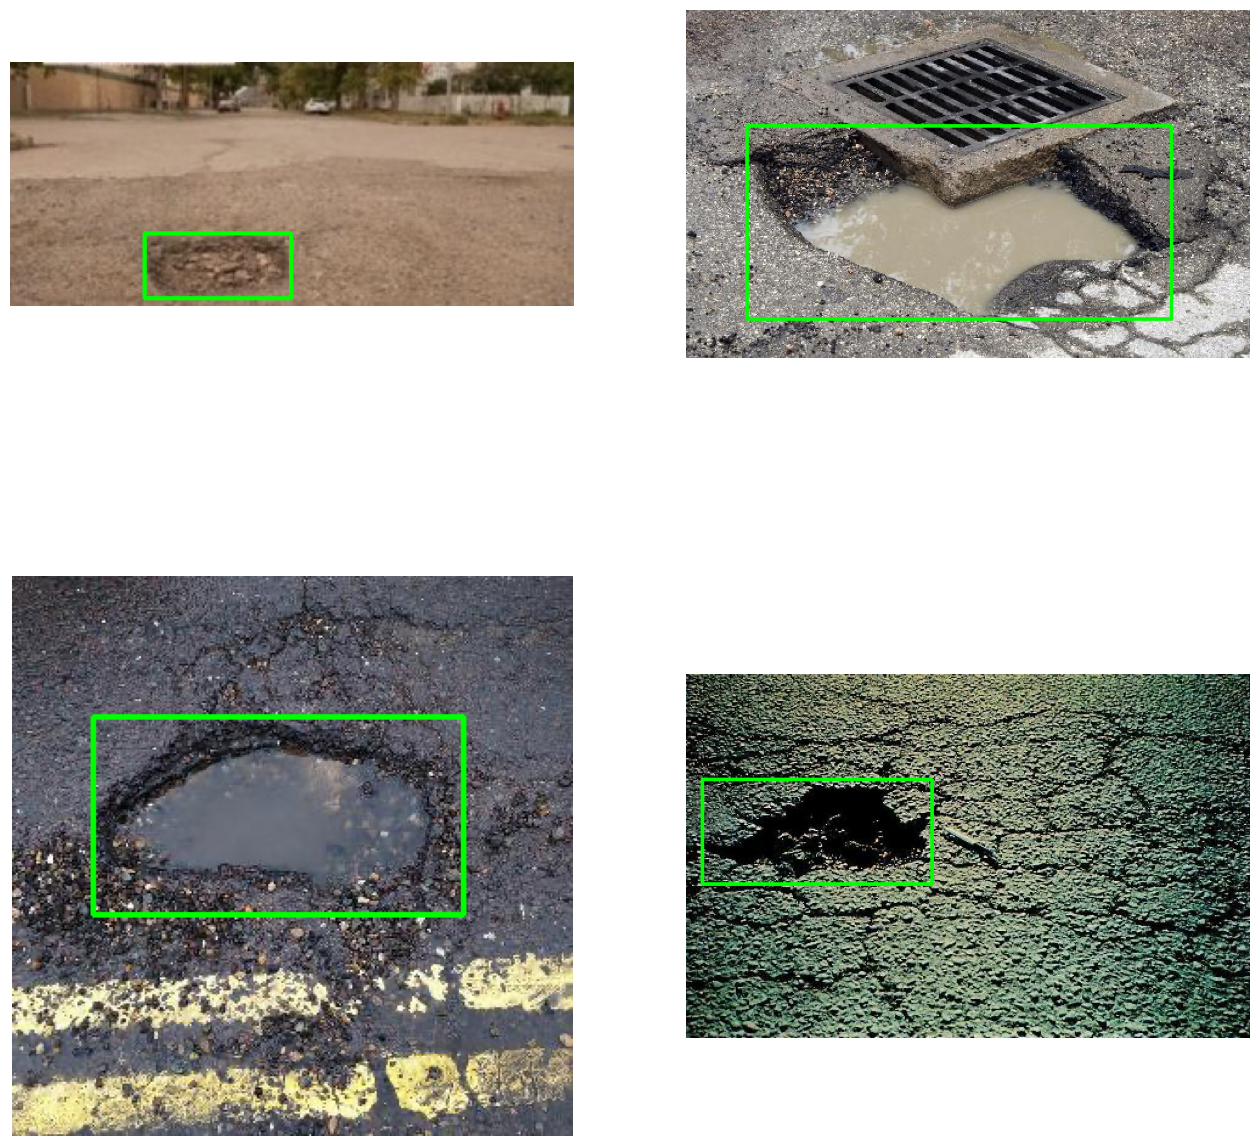

In [6]:
fig,axes=plt.subplots(2,2,figsize=(16,16))
ax=axes.flatten()

example_paths = ["dataset/images/potholes18.png", "dataset/images/potholes112.png", "dataset/images/potholes644.png", "dataset/images/potholes365.png"]
for i in range(4):
    example = data.loc[data["path"] == example_paths[i]]
    for j in range(len(example)):
        row = example.iloc[j]
        img = row["img"]
        cv2.rectangle(img, (row["xmin"],row["ymin"]), (row["xmax"],row["ymax"]), (0,255,0), 2)

    ax[i].imshow(img)
    ax[i].axis("off")

## Konfiguracja

In [7]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 4
IMG_SIZE = 256
LR = 0.01
EPOCHS = 40
MODEL_NAME = "res2net50d.in1k"
NUM_COR = 4
train_augs = A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE),
], bbox_params=A.BboxParams(format="pascal_voc",label_fields=["class_labels"]))

test_augs = A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE),
], bbox_params=A.BboxParams(format="pascal_voc",label_fields=["class_labels"]))

## Train/Test split

In [8]:
train_data, test_data = train_test_split(data, test_size=0.15, random_state=42)

In [9]:
class PotholeDataset(torch.utils.data.Dataset):
    def __init__(self,df,augs=None):
        self.df = df
        self.augs = augs

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        row = self.df.iloc[idx]
        xmin = row.xmin 
        ymin = row.ymin 
        xmax = row.xmax 
        ymax = row.ymax  
        bbox = [[xmin, ymin, xmax, ymax]]
        img = row.img

        if self.augs:
            data = self.augs(image = img, bboxes=bbox, class_labels = [None])
            img = data["image"]
           
            bbox = data["bboxes"][0]

        img = torch.from_numpy(img).permute(2,0,1) / 255.0
        bbox = torch.Tensor(bbox)

        return img, bbox

In [10]:
train_set = PotholeDataset(train_data, train_augs)
test_set = PotholeDataset(test_data, test_augs)

In [11]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
for images, bboxes in train_loader:
    break

print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([4, 3, 256, 256])
Shape of one batch bboxes : torch.Size([4, 4])


## Tworzenie modelu

In [13]:
class PotholeModel(nn.Module):
    def __init__(self) -> None:
        super(PotholeModel,self).__init__()
        self.backbone = timm.create_model(MODEL_NAME,pretrained=True,num_classes=4)


    def forward(self, images, gt_bboxes=None):
        predBboxes = self.backbone(images)

        if gt_bboxes != None:
            loss1 = torchvision.ops.complete_box_iou_loss(predBboxes,gt_bboxes,reduction="sum")
            loss2 = nn.functional.smooth_l1_loss(predBboxes,gt_bboxes)
            return predBboxes, loss2 + loss1

        return predBboxes

In [14]:
model = PotholeModel()
model.to(DEVICE)

PotholeModel(
  (backbone): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottle2neck(
        (conv1): Conv2d(64, 104, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(104, eps=1e-05, momentum=0.1, affine=True, track_running

In [15]:
def train(model, dataLoader, optimizer=torch.optim.Adam(model.parameters(), lr=LR)):
    total_loss = 0
    model.train()

    for data in tqdm(dataLoader):
        images, gt_bboxes = data
        images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
        bboxes, loss = model(images, gt_bboxes)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataLoader)

In [16]:
def eval(model, dataLoader):
    total_loss = 0
    model.eval()

    with torch.inference_mode():
        for data in tqdm(dataLoader):
            images, gt_bboxes = data
            images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
            bboxes, loss = model(images,gt_bboxes)
            total_loss += loss.item()

        return total_loss / len(dataLoader)

## Uczenie modelu + zapisanie najlepszego do pliku

In [17]:
best_test_loss = np.Inf
train_loss_list = []
test_loss_list = []

for i in range(EPOCHS):
    train_loss = train(model, train_loader)
    test_loss = eval(model, test_loader)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    if test_loss < best_test_loss:
        torch.save(model.state_dict(), "best_model.pt")
        print("Najlepszy model zapisany!")
        best_test_loss = test_loss

    print(f"Epoch: {i+1}, train Loss: {train_loss:.4f}, test loss: {test_loss:.4f}")

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Najlepszy model zapisany!
Epoch: 1, train Loss: 52.9599, test loss: 51.3014


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 2, train Loss: 49.8580, test loss: 51.3934


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Najlepszy model zapisany!
Epoch: 3, train Loss: 49.7742, test loss: 50.2847


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 4, train Loss: 50.0840, test loss: 62.5727


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 5, train Loss: 49.4793, test loss: 54.3613


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Najlepszy model zapisany!
Epoch: 6, train Loss: 49.7157, test loss: 50.0985


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Najlepszy model zapisany!
Epoch: 7, train Loss: 49.5435, test loss: 50.0067


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 8, train Loss: 49.4362, test loss: 50.1864


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 9, train Loss: 49.4318, test loss: 52.3780


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 10, train Loss: 49.2851, test loss: 50.3150


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 11, train Loss: 49.4601, test loss: 50.6072


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 12, train Loss: 49.3029, test loss: 50.5053


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 13, train Loss: 49.7629, test loss: 50.5489


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 14, train Loss: 49.8008, test loss: 50.7070


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 15, train Loss: 49.0834, test loss: 51.0198


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 16, train Loss: 49.2612, test loss: 50.9279


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 17, train Loss: 49.2432, test loss: 53.3540


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Najlepszy model zapisany!
Epoch: 18, train Loss: 49.2615, test loss: 49.9728


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 19, train Loss: 49.0111, test loss: 50.0341


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 20, train Loss: 49.0175, test loss: 50.5433


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 21, train Loss: 49.2356, test loss: 50.0423


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 22, train Loss: 49.0196, test loss: 50.3770


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 23, train Loss: 48.9798, test loss: 51.5079


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 24, train Loss: 48.8164, test loss: 50.4199


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Najlepszy model zapisany!
Epoch: 25, train Loss: 48.6193, test loss: 49.4976


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Najlepszy model zapisany!
Epoch: 26, train Loss: 48.7171, test loss: 49.2752


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 27, train Loss: 48.8489, test loss: 49.3712


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 28, train Loss: 48.6896, test loss: 51.6720


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Najlepszy model zapisany!
Epoch: 29, train Loss: 48.5316, test loss: 48.9928


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 30, train Loss: 48.5242, test loss: 49.0322


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Najlepszy model zapisany!
Epoch: 31, train Loss: 48.1125, test loss: 48.8111


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 32, train Loss: 48.4932, test loss: 49.7336


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 33, train Loss: 47.7470, test loss: 48.8781


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Najlepszy model zapisany!
Epoch: 34, train Loss: 47.6150, test loss: 48.6194


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Najlepszy model zapisany!
Epoch: 35, train Loss: 47.6697, test loss: 48.2677


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Najlepszy model zapisany!
Epoch: 36, train Loss: 47.7100, test loss: 47.8796


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Najlepszy model zapisany!
Epoch: 37, train Loss: 47.3481, test loss: 47.6142


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 38, train Loss: 47.5524, test loss: 48.3331


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 39, train Loss: 47.2716, test loss: 49.2248


  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 40, train Loss: 47.2297, test loss: 47.9524


## Wykresy kosztu

Text(0, 0.5, 'Test loss value')

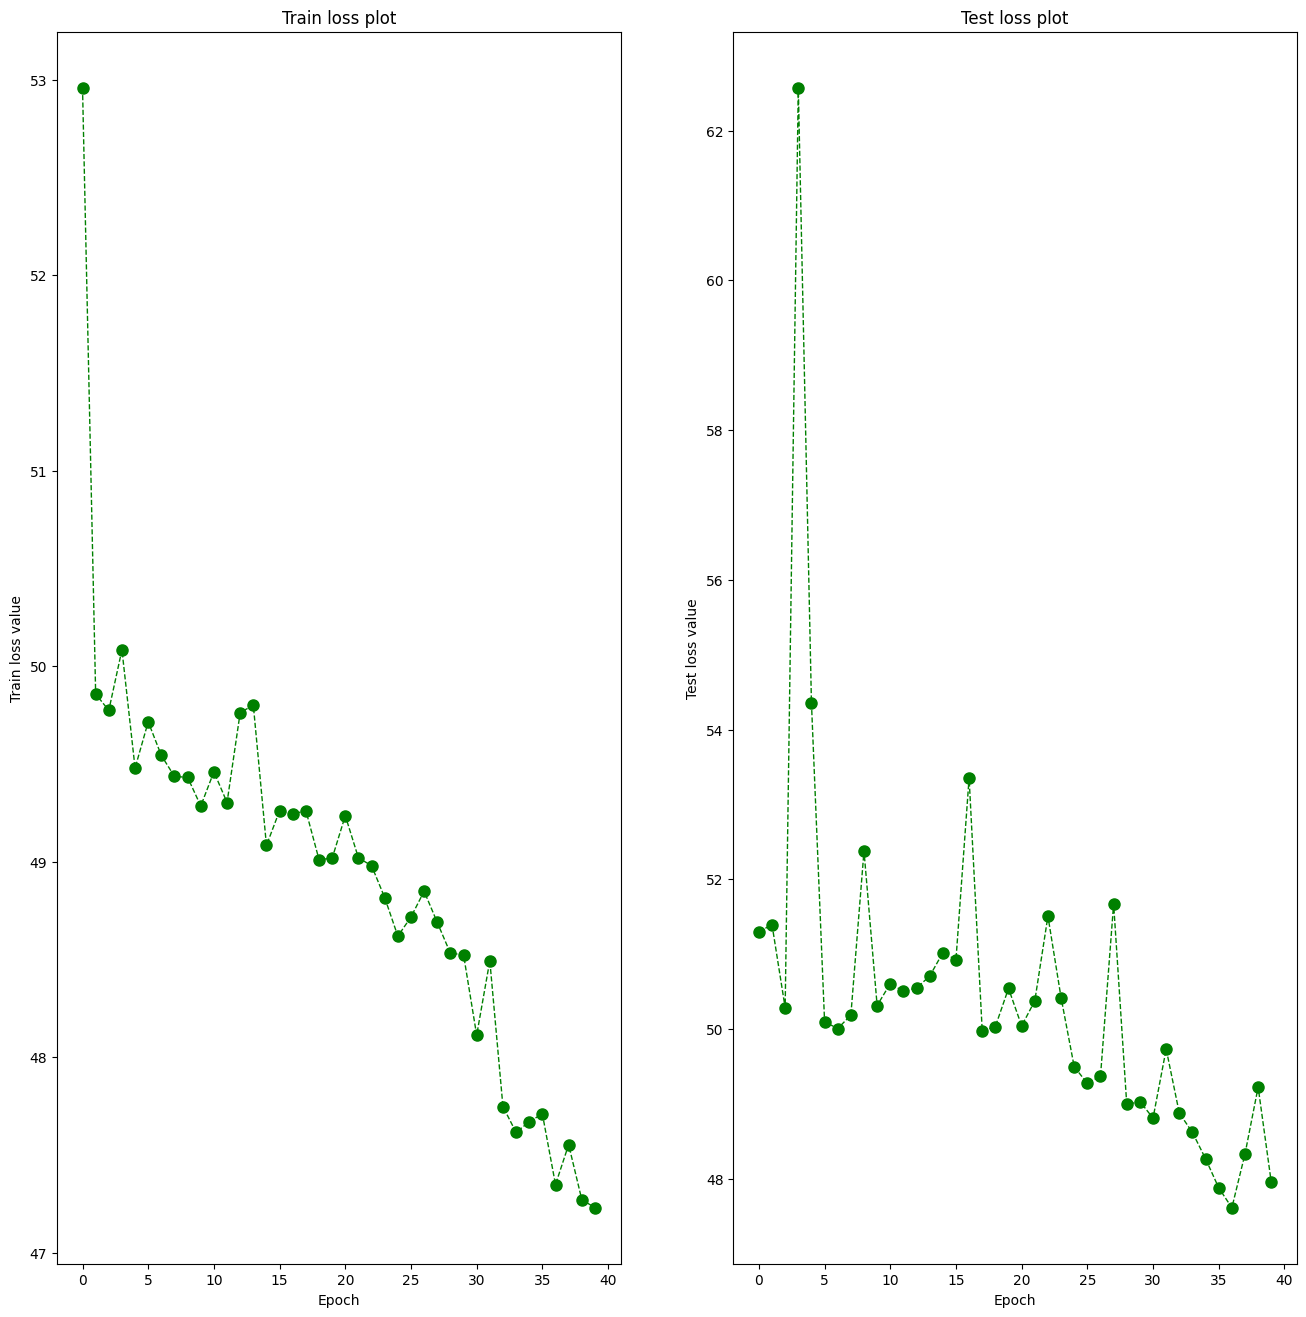

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16,16))
ax = axes.flatten()

ax[0].plot(train_loss_list, 'go--', linewidth=1, markersize=8)
ax[0].set_title("Train loss plot")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Train loss value")

ax[1].plot(test_loss_list, 'go--', linewidth=1, markersize=8)
ax[1].set_title("Test loss plot")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Test loss value")

## Przykładowe zdjęcia z predykcjami

In [19]:
def plot_prediction(ax, img, box, pred_box):

    xmin, ymin, xmax, ymax = box

    pt1 = (int(xmin), int(ymin))
    pt2 = (int(xmax), int(ymax))

    pred_xmin, pred_ymin, pred_xmax, pred_ymax = pred_box[0]

    pred_pt1 = (int(pred_xmin), int(pred_ymin))
    pred_pt2 = (int(pred_xmax), int(pred_ymax))
    
    pred_img = cv2.rectangle(img.squeeze().permute(1, 2, 0).cpu().numpy(), pt1, pt2, (0,255,0), 1)
    pred_img = cv2.rectangle(pred_img, pred_pt1, pred_pt2, (255,0,0), 2)
    ax.imshow(pred_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


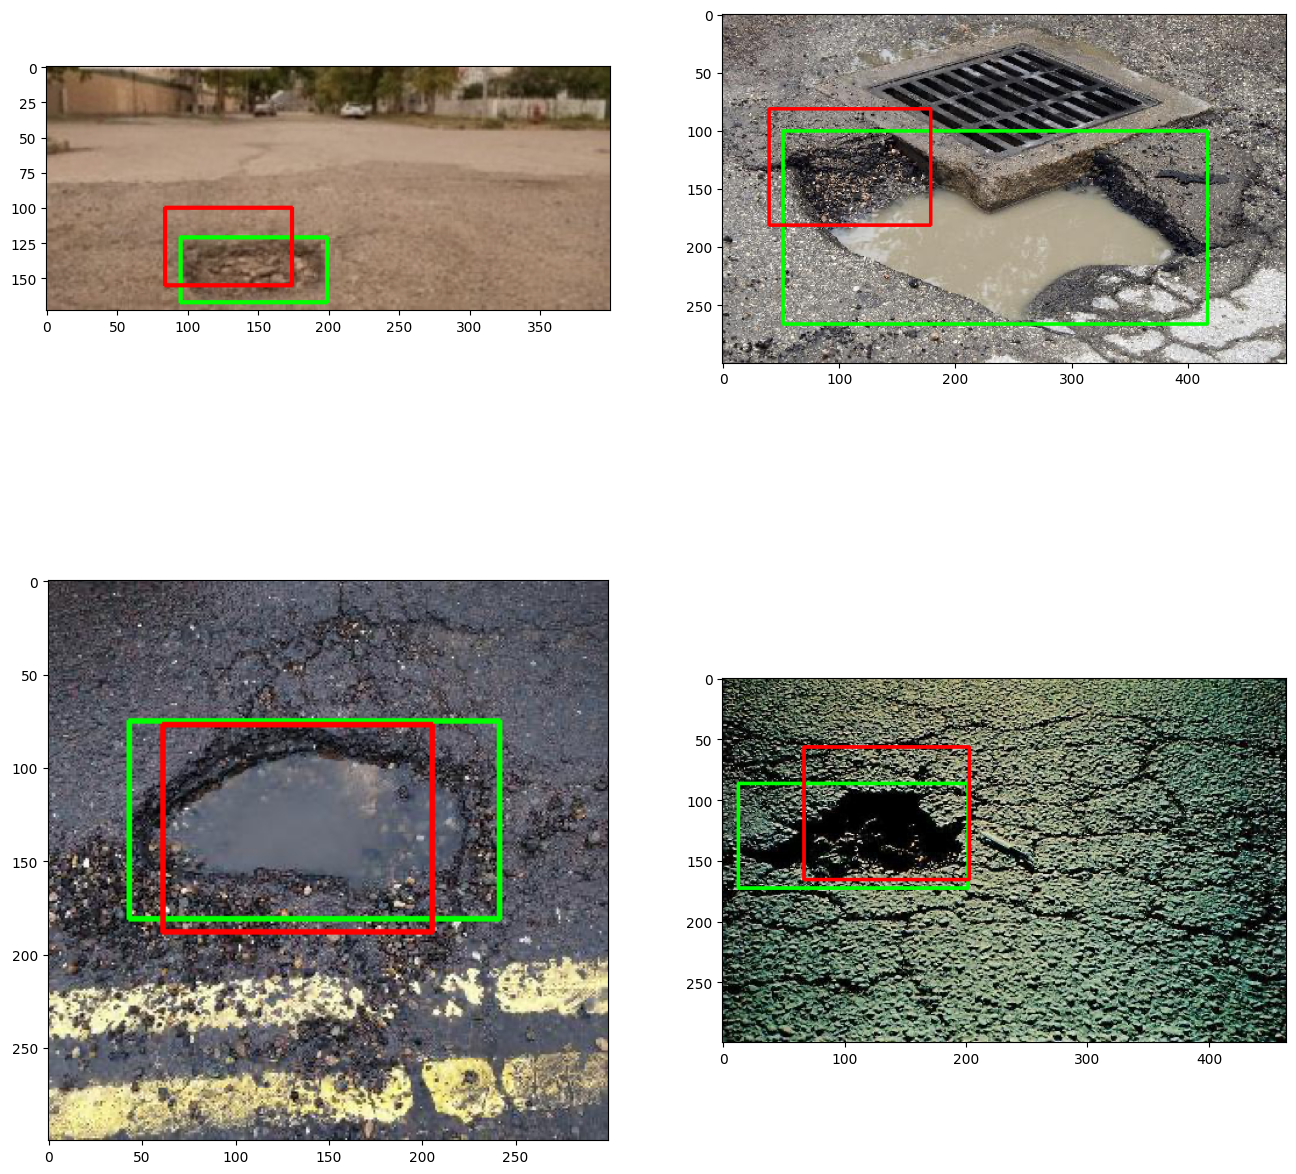

In [20]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

fig,axes=plt.subplots(2,2,figsize=(16,16))
ax=axes.flatten()

for i in range(4):
    example = data.loc[data["path"] == example_paths[i]]
    for j in range(len(example)):
        row = example.iloc[j]
        img = row["img"]
        box = [row["xmin"], row["ymin"], row["xmax"], row["ymax"]]
        
        img = torch.from_numpy(img).permute(2,0,1) / 255.0
        img = img.unsqueeze(0).to(DEVICE)
        pred_box = model(img)
        
        plot_prediction(ax[i], img, box, pred_box)

## Liczenie wielkości dziur (przy założeniu, że dziura znajduje się 1m od obiektywu aparatu)

#### W przykładach poniżej to założenie nie jest spełnione, ale wciąż można ocenić błąd predykcji

In [41]:
def calculate_actual_pothole_area(box):
    length = box[3] - box[1]
    width = box[2] - box[0]
    
    focal_length = (length * 100) / width
    focal_width = (width * 100) / length
    
    actual_length = (focal_length * length) / IMG_SIZE
    actual_width = (focal_width * width) / IMG_SIZE
    
    return actual_length * actual_width

In [42]:
def plot_prediction_with_area(ax, img, box, pred_box):

    xmin, ymin, xmax, ymax = box

    pt1 = (int(xmin), int(ymin))
    pt2 = (int(xmax), int(ymax))

    pred_xmin, pred_ymin, pred_xmax, pred_ymax = pred_box[0]

    pred_pt1 = (int(pred_xmin), int(pred_ymin))
    pred_pt2 = (int(pred_xmax), int(pred_ymax))
    
    pred_img = cv2.rectangle(img.squeeze().permute(1, 2, 0).cpu().numpy(), pt1, pt2, (0,255,0), 2)
    pred_img = cv2.rectangle(pred_img, pred_pt1, pred_pt2, (255,0,0), 2)
    ax.set_title(f"Estimated pothole area: {calculate_actual_pothole_area(pred_box[0]):.2f} cm2 (real: {calculate_actual_pothole_area(box):.2f})")
    ax.imshow(pred_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


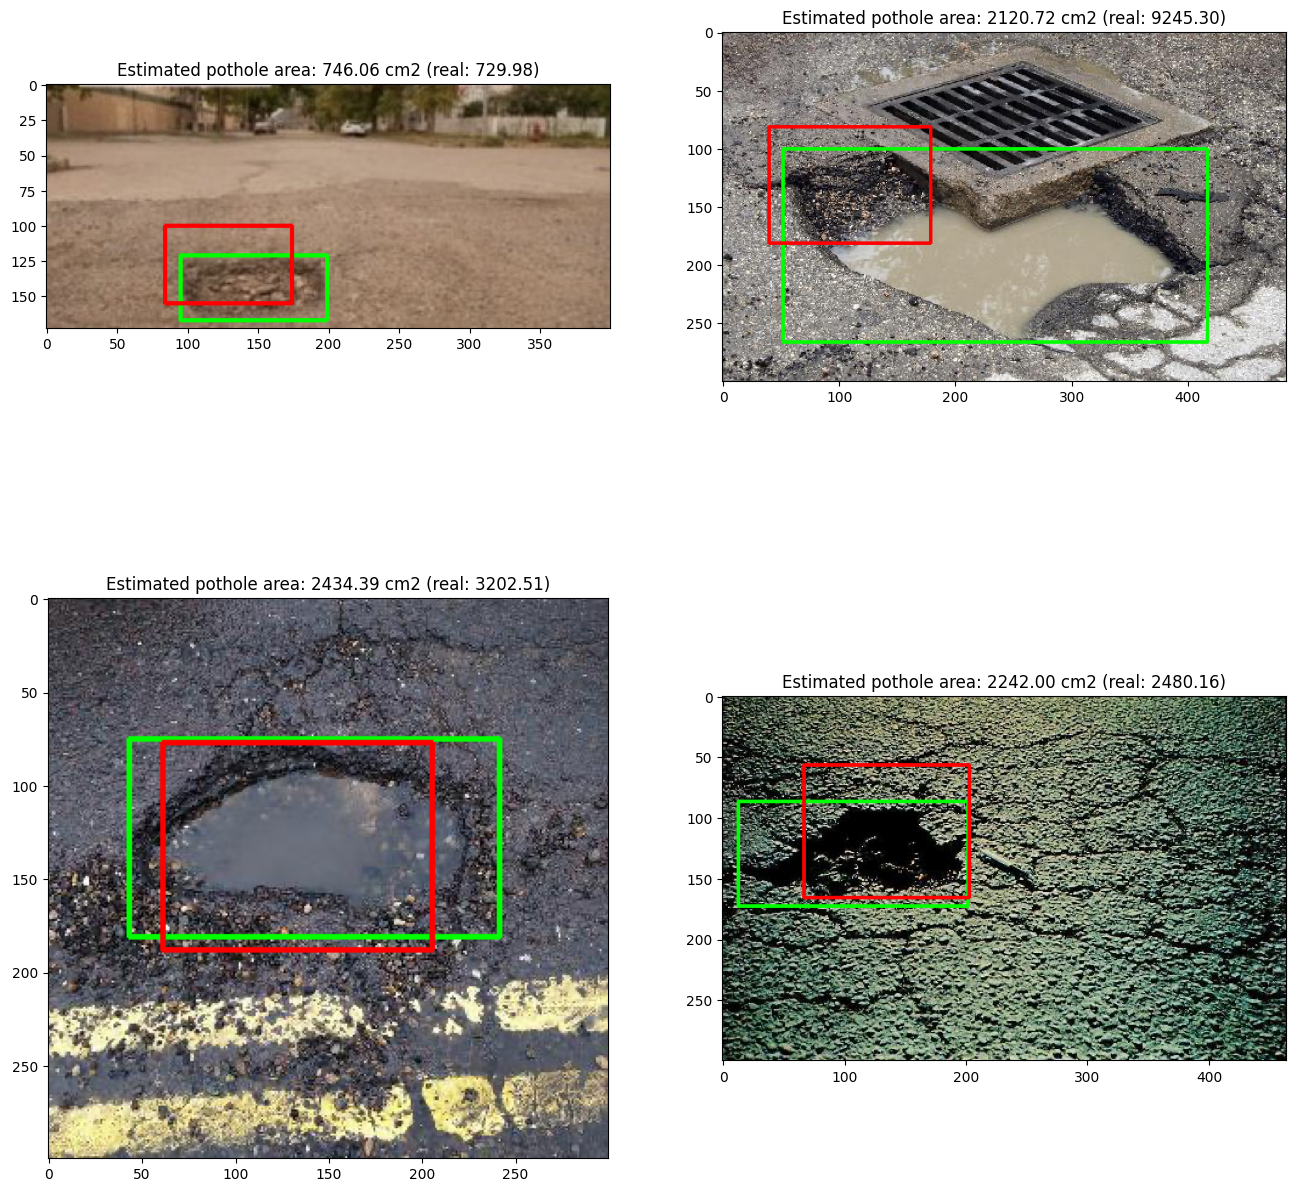

In [43]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

fig,axes=plt.subplots(2,2,figsize=(16,16))
ax=axes.flatten()

for i in range(4):
    example = data.loc[data["path"] == example_paths[i]]
    for j in range(len(example)):
        row = example.iloc[j]
        img = row["img"]
        box = [row["xmin"], row["ymin"], row["xmax"], row["ymax"]]
        
        img = torch.from_numpy(img).permute(2,0,1) / 255.0
        img = img.unsqueeze(0).to(DEVICE)
        pred_box = model(img)
        
        plot_prediction_with_area(ax[i], img, box, pred_box)